In [1]:
import numpy as np
import torch
import torch.nn as nn
from skimage.filters import gabor
from skimage import io
from skimage.util import view_as_windows
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [6]:
class PatchDataset(Dataset):
    def __init__(self, img, patch_size=256, stride=256):
        self.patches = view_as_windows(img, (patch_size, patch_size), step=stride)
        self.patches = self.patches.reshape(-1, patch_size, patch_size)

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        patch = self.patches[idx].astype(np.float32)
        patch = torch.from_numpy(patch).unsqueeze(0)  # [C,H,W]
        return patch

In [18]:
img = io.imread('https://gist.github.com/user-attachments/assets/59e4617e-d51c-4a7e-b264-7cd1b18a6f50', as_gray=True)
dataset = PatchDataset(img)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [19]:
class ThresholdModel(nn.Module):
    def __init__(self, threshold=0.5, frequency=0.2):
        super().__init__()
        self.t = threshold
        self.frequency = frequency

    def forward(self, x):
        B, C, H, W = x.shape
        outs = []
        for i in range(B):
            patch = x[i,0].numpy()
            patch_n = (patch - patch.min()) / (patch.max() - patch.min() + 1e-8)
            real, _ = gabor(patch_n, frequency=self.frequency)
            mask = (real > self.t).astype(np.uint8)
            outs.append(torch.from_numpy(mask).unsqueeze(0).unsqueeze(0).float())
        return torch.cat(outs, dim=0)

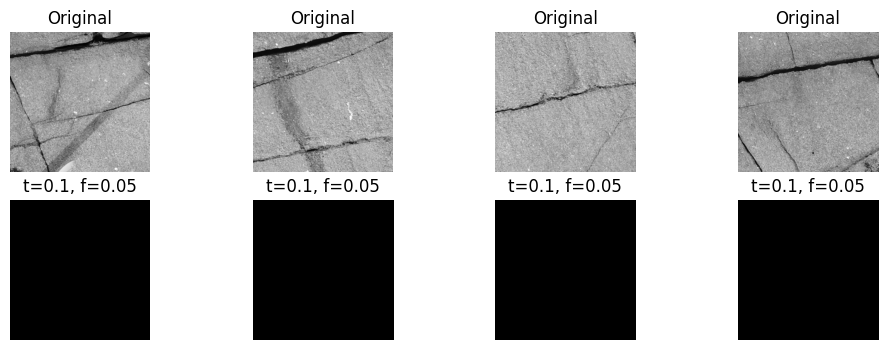

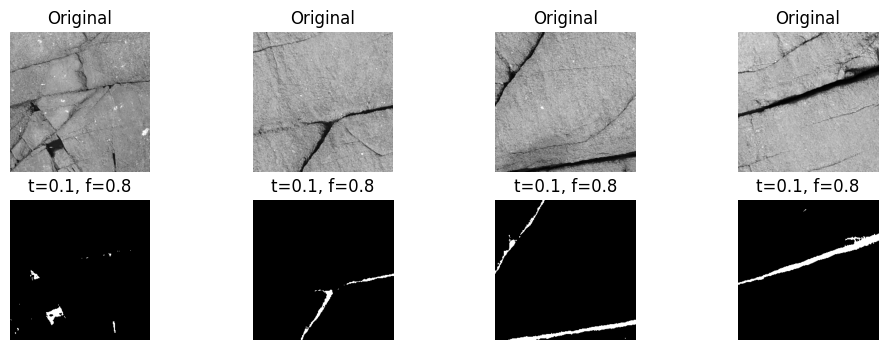

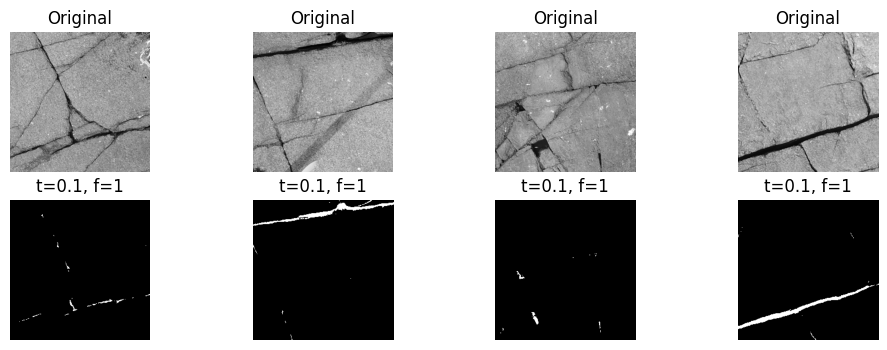

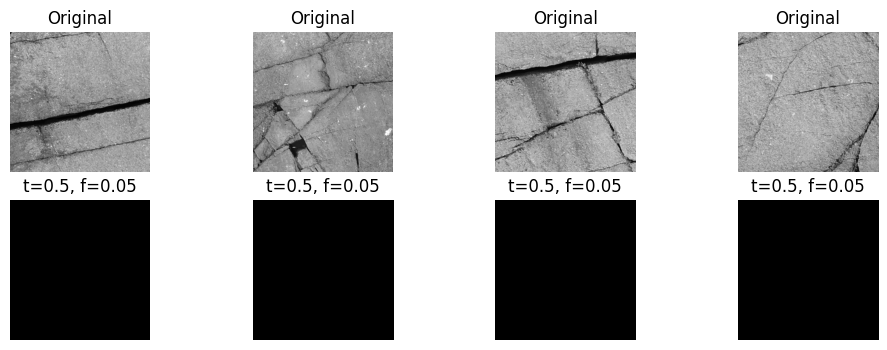

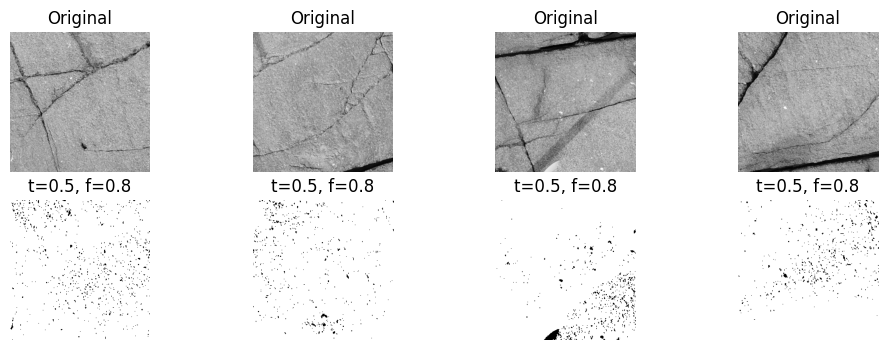

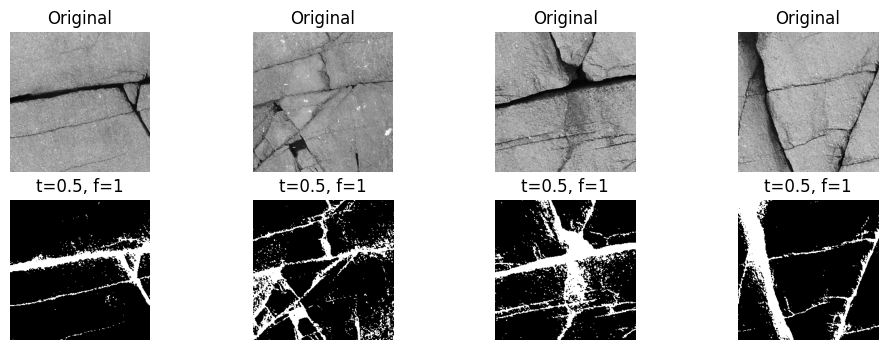

In [26]:
thresholds = [0.1, 0.5]
frequencies = [0.05, .8, 1]

for t in thresholds:
    for f in frequencies:
        model = ThresholdModel(threshold=t, frequency=f)
        batch = next(iter(loader))  # take first batch
        masks = model(batch)

        fig, axs = plt.subplots(2, len(batch), figsize=(12,4))
        for i in range(len(batch)):
            axs[0,i].imshow(batch[i,0], cmap='gray')
            axs[0,i].set_title("Original")
            axs[0,i].axis('off')
            axs[1,i].imshow(1-masks[i,0], cmap='gray')
            axs[1,i].set_title(f"t={t}, f={f}")
            axs[1,i].axis('off')
        plt.show()